<h1><strong>Introduction</strong></h1>
This is an implementation of Arificial Neural Network(ANN). For data preprocessing, I have used sklearn and for data generation, numpy. Inspired by <strong>Keras</strong> I've written the class to resemble the brilliant framework as closely as possible.

In [79]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
print(os.listdir("../input"))
np.random.seed(0)
# Any results you write to the current directory are saved as output.

['iris-dataset', 'overfit', 'ring-data']


In [80]:
types = ['f8', 'f8']
train_set = np.genfromtxt("../input/overfit/data_overfit.csv", dtype=types, delimiter=',',names=True)
#enc=LabelEncoder()
#sca=MinMaxScaler()
#y=enc.fit_transform(train_set[:,2])
#train_set[:,2]=y
#trainY=np.eye(2)[train_set[:,2].astype(int)]
data=[]
for tup in train_set:
    data.append(list(tup))
data=np.array(data)
np.random.shuffle(data)
'''sca.fit(trainX)
trainX=sca.transform(trainX)'''

'sca.fit(trainX)\ntrainX=sca.transform(trainX)'

<h1><strong>Making the splits</strong></h1>
Splitting the dataset into train,test and validation sets

In [83]:
trainX,trainY=data[:4,0].reshape(-1,1),data[:4,1].reshape(-1,1)
testX,testY=data[4:,0].reshape(-1,1),data[4:,1].reshape(-1,1)

In [84]:
print(trainX.shape,trainY.shape)
#print(valX.shape,valY.shape)
print(testX.shape,testY.shape)

(4, 1) (4, 1)
(135, 1) (135, 1)


<h1><strong>Lets Plot</strong><h1>

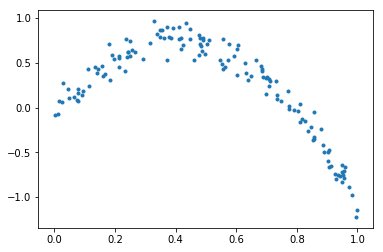

In [85]:
plt.scatter(data[:,0], data[:,1], marker='.')

In [86]:
#utility sigmoid activation function
def sigmoid(x):
    return 1/(1+np.exp(-x))

<h1><strong>The actual Model class for ANN </strong></h1>

In [87]:
#the actual class that gives the model
class Model:
    def __init__(self):
        self.layer_count=0
        self.weights={}
        self.biases={}
        self.l_dims=[]
        self.grad_W={}
        self.grad_b={}
        self.layer_ops={} #stores the output of each layer.
        self.summary={} #stores the name and shape of each layer
        self.history={"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[]}
        self.best=None
    
    #returns the layer parameters
    def Dense(self,nodes=1,input_shape=None):
        self.layer_count+=1
        if input_shape:
            self.l_dims.append(input_shape)
        self.l_dims.append(nodes)
        return np.random.random_sample((nodes,self.l_dims[self.layer_count-1])),np.random.random_sample((nodes,1))
        
    #adds the weights passed as layers
    def add(self,weights):
        self.weights[f"w_{self.layer_count}"]=weights[0]
        self.biases[f"b_{self.layer_count}"]=weights[1]
        self.summary[f"Dense_{self.layer_count}"]=weights[0].shape
        
    def predict(self,x):
        self.layer_ops["v_0"]=x
        for i in range(self.layer_count-1):
            x=self.layer_ops[f"v_{i}"]
            x=np.dot(x,self.weights[f'w_{i+1}'].T)
            x=np.add(x,self.biases[f"b_{i+1}"].T)
            x=sigmoid(x)
            self.layer_ops[f'v_{i+1}']=x #saving the layer output
        x=np.dot(x,self.weights[f'w_{self.layer_count}'].T)
        self.layer_ops[f'v_{self.layer_count}']=x
        return x
    
    def fit(self,X,Y,validation_data=None,epochs=100000,batch_size=1,lr=0.005):
        batches=X.shape[0]//batch_size
        best_acc=0
        if validation_data:
            valX,valY=validation_data
        for e in range(epochs):
            loss=0
            for i in range(batches):
                x=X[i*batch_size:i+1*batch_size]
                y=Y[i*batch_size:i+1*batch_size]
                v=self.predict(x)
                grad_base=((v-y)).T #the centerpiece of the gardient for every layer
                for j in reversed(range(1,self.layer_count+1)):
                    self.grad_W[f'{"w_"}{j}']=grad_base
                    #calculation of gradient for each layer
                    for k in reversed(range(j,self.layer_count)):
                        self.grad_W[f'{"w_"}{j}']=np.dot(self.weights[f'{"w_"}{k+1}'].T,self.grad_W[f'{"w_"}{j}'])
                        self.grad_W[f'{"w_"}{j}']=self.grad_W[f'{"w_"}{j}']*(self.layer_ops[f'{"v_"}{k}']*
                                                                             (1-self.layer_ops[f'{"v_"}{k}'])).T
                    self.grad_b[f"b_{j}"]=np.sum(self.grad_W[f"w_{j}"],axis=1).reshape(self.biases[f"b_{j}"].shape) #bias gradient
                    self.grad_W[f'{"w_"}{j}']=np.dot(self.grad_W[f'{"w_"}{j}'],self.layer_ops[f'{"v_"}{j-1}']) #weight gradient
                    #bias and weights adjustment
                    self.weights[f'{"w_"}{j}']-=lr*self.grad_W[f'{"w_"}{j}']
                    self.biases[f'b_{j}']-=lr*self.grad_b[f"b_{j}"]
                    #self.weights[f'{"w_"}{j}']/=trainX.shape[0]
                    #self.biases[f'{"b_"}{j}']/=trainX.shape[0]
                loss+=np.sum((v-y)*(v-y))/(2*batch_size) #batch loss aggregation
            val_loss=0
            train_acc=accuracy_score(np.argmax(trainY,axis=1),np.argmax(self.predict(trainX),axis=1))
            #saving performance on train set
            self.history["train_acc"].append(train_acc)
            self.history["train_loss"].append(loss)
            label=self.predict(trainX)
            #validation
            if validation_data:
                val_v=self.predict(valX)
                #print(val_v.shape,valY.shape)
                val_loss+=np.sum((val_v-valY)*(val_v-valY))/(2*valX.shape[0])
                val_acc=accuracy_score(np.argmax(valY,axis=1),np.argmax(self.predict(valX),axis=1))
                self.history["val_acc"].append(val_acc)
                self.history["val_loss"].append(val_loss)
                if best_acc<val_acc:
                    self.best=Model()
                    for key,value in self.weights.items():
                        self.best.weights[key]=np.copy(value)
                    for key,value in self.biases.items():
                        self.best.biases[key]=np.copy(value)
                    best_acc=val_acc
                print(f"epoch {e}  train loss: {loss}  validation loss:{val_loss}")
            else:
                print(f"epoch {e}  train loss: {loss} ")

<h1><strong> Creation and fitting of the model </strong></h1>

Works fine for one layer. Learns but underfits.

In [88]:
model=Model()
model.add(model.Dense(nodes=6,input_shape=trainX.shape[1]))
model.add(model.Dense(nodes=7))
model.add(model.Dense(nodes=7))
model.add(model.Dense(trainY.shape[1]))
model.fit(trainX[:4],trainY[:4],validation_data=[testX,testY],batch_size=1,epochs=200000,lr=0.01)

epoch 0  train loss: 17.857424149732168  validation loss:3.768432304926361
epoch 1  train loss: 10.396898758839006  validation loss:2.338766903350849
epoch 2  train loss: 6.096850644489643  validation loss:1.4916433740255313
epoch 3  train loss: 3.615614785902496  validation loss:0.9855024631773089
epoch 4  train loss: 2.1824733669374754  validation loss:0.6800932558436291
epoch 5  train loss: 1.3538868842446043  validation loss:0.4936440872052367
epoch 6  train loss: 0.8742981176742642  validation loss:0.3782616284420123
epoch 7  train loss: 0.5963365981018042  validation loss:0.3057457735220489
epoch 8  train loss: 0.4349619777189337  validation loss:0.259385351228697
epoch 9  train loss: 0.3410708742843407  validation loss:0.22919983665206392
epoch 10  train loss: 0.2862913713201549  validation loss:0.20917174084911586
epoch 11  train loss: 0.2542172431299725  validation loss:0.19563158196149613
epoch 12  train loss: 0.23535218298932242  validation loss:0.18631170995859286
epoch 13 

epoch 163  train loss: 0.20689290072173472  validation loss:0.16234734182073726
epoch 164  train loss: 0.20689290390896645  validation loss:0.1623473417357618
epoch 165  train loss: 0.206892907096158  validation loss:0.16234734165078776
epoch 166  train loss: 0.20689291028330975  validation loss:0.16234734156581507
epoch 167  train loss: 0.20689291347042155  validation loss:0.16234734148084376
epoch 168  train loss: 0.20689291665749338  validation loss:0.16234734139587378
epoch 169  train loss: 0.2068929198445251  validation loss:0.1623473413109052
epoch 170  train loss: 0.206892923031517  validation loss:0.1623473412259379
epoch 171  train loss: 0.20689292621846875  validation loss:0.1623473411409721
epoch 172  train loss: 0.2068929294053808  validation loss:0.16234734105600757
epoch 173  train loss: 0.20689293259225283  validation loss:0.16234734097104436
epoch 174  train loss: 0.20689293577908477  validation loss:0.1623473408860826
epoch 175  train loss: 0.2068929389658768  validati

epoch 320  train loss: 0.20689340062813863  validation loss:0.1623473284962595
epoch 321  train loss: 0.20689340380910456  validation loss:0.1623473284114976
epoch 322  train loss: 0.20689340699003056  validation loss:0.16234732832673712
epoch 323  train loss: 0.20689341017091673  validation loss:0.16234732824197795
epoch 324  train loss: 0.20689341335176312  validation loss:0.16234732815722017
epoch 325  train loss: 0.2068934165325696  validation loss:0.16234732807246371
epoch 326  train loss: 0.2068934197133361  validation loss:0.1623473279877086
epoch 327  train loss: 0.20689342289406293  validation loss:0.1623473279029549
epoch 328  train loss: 0.2068934260747499  validation loss:0.16234732781820252
epoch 329  train loss: 0.20689342925539694  validation loss:0.16234732773345148
epoch 330  train loss: 0.20689343243600414  validation loss:0.16234732764870186
epoch 331  train loss: 0.20689343561657159  validation loss:0.16234732756395356
epoch 332  train loss: 0.20689343879709904  val

epoch 486  train loss: 0.206893928123242  validation loss:0.16234731444437658
epoch 487  train loss: 0.2068939312976022  validation loss:0.16234731435983996
epoch 488  train loss: 0.20689393447192295  validation loss:0.16234731427530466
epoch 489  train loss: 0.20689393764620373  validation loss:0.1623473141907707
epoch 490  train loss: 0.20689394082044488  validation loss:0.16234731410623812
epoch 491  train loss: 0.20689394399464633  validation loss:0.16234731402170688
epoch 492  train loss: 0.20689394716880802  validation loss:0.16234731393717702
epoch 493  train loss: 0.2068939503429299  validation loss:0.1623473138526485
epoch 494  train loss: 0.20689395351701215  validation loss:0.1623473137681213
epoch 495  train loss: 0.20689395669105456  validation loss:0.16234731368359553
epoch 496  train loss: 0.20689395986505743  validation loss:0.16234731359907106
epoch 497  train loss: 0.20689396303902058  validation loss:0.16234731351454795
epoch 498  train loss: 0.20689396621294381  val

epoch 650  train loss: 0.20689444818779779  validation loss:0.1623473005984625
epoch 651  train loss: 0.20689445135565168  validation loss:0.16234730051414778
epoch 652  train loss: 0.20689445452346608  validation loss:0.16234730042983445
epoch 653  train loss: 0.20689445769124068  validation loss:0.16234730034552244
epoch 654  train loss: 0.20689446085897575  validation loss:0.16234730026121183
epoch 655  train loss: 0.20689446402667122  validation loss:0.16234730017690255
epoch 656  train loss: 0.20689446719432714  validation loss:0.1623473000925946
epoch 657  train loss: 0.20689447036194322  validation loss:0.162347300008288
epoch 658  train loss: 0.20689447352951987  validation loss:0.1623472999239828
epoch 659  train loss: 0.20689447669705688  validation loss:0.1623472998396789
epoch 660  train loss: 0.20689447986455428  validation loss:0.1623472997553764
epoch 661  train loss: 0.20689448303201213  validation loss:0.16234729967107522
epoch 662  train loss: 0.2068944861994302  vali

epoch 813  train loss: 0.2068949640254677  validation loss:0.16234728687299851
epoch 814  train loss: 0.20689496718687395  validation loss:0.16234728678890384
epoch 815  train loss: 0.2068949703482406  validation loss:0.1623472867048106
epoch 816  train loss: 0.20689497350956787  validation loss:0.16234728662071865
epoch 817  train loss: 0.20689497667085574  validation loss:0.16234728653662803
epoch 818  train loss: 0.20689497983210417  validation loss:0.16234728645253876
epoch 819  train loss: 0.2068949829933128  validation loss:0.16234728636845083
epoch 820  train loss: 0.20689498615448218  validation loss:0.1623472862843643
epoch 821  train loss: 0.206894989315612  validation loss:0.1623472862002791
epoch 822  train loss: 0.2068949924767024  validation loss:0.16234728611619523
epoch 823  train loss: 0.2068949956377531  validation loss:0.16234728603211268
epoch 824  train loss: 0.20689499879876455  validation loss:0.16234728594803152
epoch 825  train loss: 0.20689500195973637  valida

epoch 982  train loss: 0.20689549774299384  validation loss:0.1623472726801275
epoch 983  train loss: 0.20689550089773534  validation loss:0.16234727259626042
epoch 984  train loss: 0.2068955040524373  validation loss:0.16234727251239467
epoch 985  train loss: 0.2068955072071  validation loss:0.16234727242853025
epoch 986  train loss: 0.2068955103617232  validation loss:0.16234727234466723
epoch 987  train loss: 0.2068955135163072  validation loss:0.1623472722608055
epoch 988  train loss: 0.20689551667085176  validation loss:0.1623472721769452
epoch 989  train loss: 0.2068955198253569  validation loss:0.1623472720930862
epoch 990  train loss: 0.20689552297982278  validation loss:0.1623472720092285
epoch 991  train loss: 0.20689552613424914  validation loss:0.1623472719253722
epoch 992  train loss: 0.20689552928863628  validation loss:0.16234727184151723
epoch 993  train loss: 0.20689553244298384  validation loss:0.16234727175766359
epoch 994  train loss: 0.2068955355972922  validation 

epoch 1125  train loss: 0.20689594847156995  validation loss:0.1623472607007792
epoch 1126  train loss: 0.20689595162068775  validation loss:0.16234726061710422
epoch 1127  train loss: 0.20689595476976638  validation loss:0.1623472605334306
epoch 1128  train loss: 0.20689595791880566  validation loss:0.16234726044975828
epoch 1129  train loss: 0.20689596106780572  validation loss:0.1623472603660873
epoch 1130  train loss: 0.20689596421676643  validation loss:0.16234726028241772
epoch 1131  train loss: 0.20689596736568788  validation loss:0.16234726019874945
epoch 1132  train loss: 0.2068959705145701  validation loss:0.1623472601150825
epoch 1133  train loss: 0.206895973663413  validation loss:0.16234726003141695
epoch 1134  train loss: 0.2068959768122167  validation loss:0.16234725994775265
epoch 1135  train loss: 0.2068959799609811  validation loss:0.16234725986408977
epoch 1136  train loss: 0.20689598310970628  validation loss:0.1623472597804282
epoch 1137  train loss: 0.206895986258

epoch 1289  train loss: 0.20689646440246737  validation loss:0.16234724699600162
epoch 1290  train loss: 0.20689646754515387  validation loss:0.16234724691254646
epoch 1291  train loss: 0.20689647068780107  validation loss:0.16234724682909257
epoch 1292  train loss: 0.2068964738304091  validation loss:0.16234724674564002
epoch 1293  train loss: 0.20689647697297786  validation loss:0.1623472466621888
epoch 1294  train loss: 0.20689648011550757  validation loss:0.16234724657873897
epoch 1295  train loss: 0.20689648325799817  validation loss:0.16234724649529045
epoch 1296  train loss: 0.20689648640044953  validation loss:0.16234724641184328
epoch 1297  train loss: 0.20689648954286183  validation loss:0.16234724632839745
epoch 1298  train loss: 0.20689649268523494  validation loss:0.16234724624495298
epoch 1299  train loss: 0.20689649582756886  validation loss:0.16234724616150978
epoch 1300  train loss: 0.2068964989698636  validation loss:0.16234724607806802
epoch 1301  train loss: 0.20689

epoch 1449  train loss: 0.20689696673466568  validation loss:0.16234723366017906
epoch 1450  train loss: 0.20689696987109565  validation loss:0.16234723357693776
epoch 1451  train loss: 0.20689697300748672  validation loss:0.16234723349369776
epoch 1452  train loss: 0.20689697614383873  validation loss:0.16234723341045912
epoch 1453  train loss: 0.2068969792801516  validation loss:0.16234723332722178
epoch 1454  train loss: 0.20689698241642548  validation loss:0.16234723324398576
epoch 1455  train loss: 0.20689698555266026  validation loss:0.1623472331607511
epoch 1456  train loss: 0.20689698868885614  validation loss:0.1623472330775178
epoch 1457  train loss: 0.2068969918250129  validation loss:0.16234723299428583
epoch 1458  train loss: 0.20689699496113056  validation loss:0.1623472329110552
epoch 1459  train loss: 0.20689699809720927  validation loss:0.1623472328278259
epoch 1460  train loss: 0.20689700123324897  validation loss:0.1623472327445979
epoch 1461  train loss: 0.206897004

KeyboardInterrupt: 

<h1><strong>Visualization of the Model History</strong></h1>

In [ ]:
# Plot training & validation loss values/
plt.plot(model.history['train_loss'])
plt.plot(model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<h1><strong>Testing it out</strong></h1>

The accuracy does'nt seem to be great. So let's see whether it did better than at least a linear model.

In [ ]:
yout=model.predict(data[:,0].reshape((-1,1)))
plt.scatter(data[:,0],yout,marker='.')

In [ ]:
plt.figure()
plt.scatter(data[:,0], data[:,1], marker='.',)
plt.scatter(data[:,0],yout,marker='.',color=["orange"])
plt.show()